
# Law Replication: Critical Temperatures and Pressures of H2-Air & Me-Air Mixtures

This Code tries to calculate and compare critical Pressures and Temperatures of Hydrogen-Air and Methane-Air mixtures. \
We obtain the these properties from:
1. Using Kays Rule on CoolProps/NISTs pure species values (pseudocritical, ideal approximation)
2. Using the Van-der-Waals one fluid mixing rule (pseudocritical)
4. CoolProps all_critical_points function (should be more accurate, but has its own pitfalls)
5. Reference values from Liang, Chung K. Law et al's paper (https://doi.org/10.1016/j.proci.2018.06.070). To get the data - which was only present graphically - WebPlotDigitizer (https://apps.automeris.io/wpd4/) was used and the results saved in csv files (see subfolder /Extracted Plots)

We investigate the discrepancies in our H2-Air results by manually tuning some of the binary interaction parameters in the H2-Air pairings (HEOS & Cubics).

At the time of writing this, CoolProps still has its clear limitations with mixtures in available flashpoint routines, robustness of backends and accuracy of obtained results. This will be demonstrated here.

Sources: \
Burke Mechanism: https://burke.me.columbia.edu/sites/burke.me.columbia.edu/files/content/chem_cti.txt \
Cantera Critical State Properties: https://cantera.org/stable/examples/python/thermo/critical_properties.html \
Coolprop Cubic EOS: http://www.coolprop.org/coolprop/Cubics.html \
Coolprop Mixture Handling: http://www.coolprop.org/dev/fluid_properties/Mixtures.html \
Coolprop Low Level Interface: http://www.coolprop.org/coolprop/LowLevelAPI.html

In [1]:
#Imports
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI
# !pip install pandas if you dont have it
import pandas as pd

Querying critical properties of Mixtures directly in Cantera is currently not implemented:

In [2]:
gas1.critical_temperature()
#gas1.critical_pressure()

NameError: name 'gas1' is not defined

This is why we investigate alternatives here!

First we grab the Critical Properties of Pure fluids from Canteras built-in EOSs and Coolprops EOS, to compare them to the values found in the NIST Database. \
Canteras code is analogous to Canteras Critical State Properties example. \

In [3]:
fluids = {'N2': ct.Nitrogen(),
          'CH4': ct.Methane(),
          'H2': ct.Hydrogen(),
          'O2': ct.Oxygen(),
          }
print('Critical State Properties')
print(f"{'Fluid':^16s}   {'Tc [K]':^7s}   {'Pc [Atm]':^10s} {'Zc':^7s}")
print(f"{'-'*16}   {'-'*7}   {'-'*10} {'-'*7}")

for name in fluids:
    f = fluids[name]
    tc = f.critical_temperature
    pc = f.critical_pressure
    rc = f.critical_density
    mw = f.mean_molecular_weight # g/kmol
    zc = pc * mw / (rc * ct.gas_constant * tc)
    print(f'{name:16s}   {tc:7.2f}   {pc/101325:10.4g} {zc:7.4f}')


print()
print('Critical State Properties in Coolprop')
print(f"{'Fluid':^16s}   {'Tc [K]':^7s}   {'Pc [Atm]':^10s} {'Zc':^7s}")
print(f"{'-'*16}   {'-'*7}   {'-'*10} {'-'*7}")

# PropsSI doesn't like using indexes in its function
# That is why we need to use CoolProps low level interface, which does accept these inputs
CP_fluids = ['N2', 'CH4', 'H2', 'O2']

for X in CP_fluids:
    name1 = X
    tc1 = PropsSI("Tcrit", X)
    pc1 = PropsSI("pcrit", X)
    rc1 = PropsSI("rhocrit", X)
    mw1 = PropsSI("molemass", "P", 101325, "T", 300, X) # kg/mol
    zc1 = pc1 * mw1 * 1000 / (rc1 * ct.gas_constant * tc1) # Increased by a factor of 1000 due to unit change
    print(f'{name1:16s}   {tc1:7.2f}   {pc1/101325:10.4g} {zc1:7.4f}')

NIST_Crit = pd.read_csv('NIST Reference Critical Properties.csv')
#NIST_Crit.head()

print()
print('NIST Reference Critical State Properties')
print(f"{'Fluid':^16s}   {'Tc [K]':^7s}   {'Pc [Atm]':^10s} {'Zc':^7s}")
print(f"{'-'*16}   {'-'*7}   {'-'*10} {'-'*7}")

for i in range(len(NIST_Crit)):
    tc2 = NIST_Crit.iloc[i, 2]
    pc2 = NIST_Crit.iloc[i, 3] # atm
    rc2 = NIST_Crit.iloc[i, 4]
    mw2 = NIST_Crit.iloc[i, 1] # g/mol
    zc2 = pc2 * 101325 * mw2 / (rc2 * ct.gas_constant * tc2) # Increased by atm-Pa factor
    print(f'{NIST_Crit.iloc[i, 0]:16s}   {tc2:7.2f}   {pc2:10.4g} {zc2:7.4f}')

Critical State Properties
     Fluid         Tc [K]     Pc [Atm]    Zc   
----------------   -------   ---------- -------
N2                  126.20        33.56  0.2891
CH4                 190.56        45.39  0.2904
H2                   32.94        12.67  0.3013
O2                  154.58        49.77  0.2879

Critical State Properties in Coolprop
     Fluid         Tc [K]     Pc [Atm]    Zc   
----------------   -------   ---------- -------
N2                  126.19        33.51  0.2894
CH4                 190.56        45.39  0.2863
H2                   33.15        12.79  0.3033
O2                  154.58        49.77  0.2879


FileNotFoundError: [Errno 2] No such file or directory: 'NIST Reference Critical Properties.csv'

Canteras PureFluid critical Properties have slight discrepancies for H2 and N2, but are overall quite accurate. \
CoolProps values are spot on with the NIST reference. \

Now to calculate critical properties of Mixtures: \
We set up a range of equivalence ratios between 0.6 and 2 (same as Fig. 2 of paper)

In [4]:
phi = np.linspace(0.6,2, 29)
print (phi)

[0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25
 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95
 2.  ]


We will first be utilizing Kays Law. It states, that the critical properties of a gas mixture can be estimated as the mole-fraction weighted average of the corresponding critical properties of the pure components.
We will use CoolProps Purefluid values for this.

In order to not have to do molar fractions manually, we set up two gas objects, then use Canteras "set_equivalence_ratio" on them to calculate the fractions for us:

In [5]:
#2 Objects, 1 for H2, one for CH4
gas1 = ct.Solution('gri30.yaml')
gas2 = ct.Solution('gri30.yaml')

fuel = 'H2:1'
fuel2 = 'CH4:1'
oxidizer = 'O2:0.21,N2:0.79'

gas1.set_equivalence_ratio(1, fuel, oxidizer)
gas2.set_equivalence_ratio(1, fuel2, oxidizer)
#After setting the equivalence ratio, the molar fractions get automatically adjusted, and can be obtained with gas1.X[species_index]
#The species index is obtained with gas1.X[gas1.species_index('GAS')]

In [6]:
#Arrays for final values
T_c_mix_H2 = []
P_c_mix_H2 = []
T_c_mix_CH4 = []
P_c_mix_CH4 = []

# Main Loops
for i in phi:
    gas1.set_equivalence_ratio(i, fuel, oxidizer)
    #Defining species, mole fractions
    mole_fractions = {
    'N2': gas1.X[gas1.species_index('N2')],
    'H2': gas1.X[gas1.species_index('H2')],
    'O2': gas1.X[gas1.species_index('O2')]
    }
    T_temp = 0
    P_temp = 0
    for species, y in mole_fractions.items():
        T_ci = PropsSI('Tcrit', species)
        P_ci = PropsSI('Pcrit', species)
        T_temp += y * T_ci
        P_temp += y * P_ci
    T_c_mix_H2.append (T_temp)
    P_c_mix_H2.append (P_temp/101325) #atm

for i in phi:
    gas2.set_equivalence_ratio(i, fuel2, oxidizer)
    mole_fractions = {
    'N2': gas2.X[gas2.species_index('N2')],
    'CH4': gas2.X[gas2.species_index('CH4')],
    'O2': gas2.X[gas2.species_index('O2')]
    }
    T_temp = 0
    P_temp = 0
    for species, y in mole_fractions.items():
        T_ci = PropsSI('Tcrit', species)
        P_ci = PropsSI('Pcrit', species)
        T_temp += y * T_ci
        P_temp += y * P_ci
    T_c_mix_CH4.append (T_temp)
    P_c_mix_CH4.append (P_temp/101325) #atm

In [7]:
#print (T_c_mix_CH4)
#print (P_c_mix_H2)

Now to do Van-der-Waals mixing: All Formulas are from Page 241, 242 of https://nvlpubs.nist.gov/nistpubs/jres/121/jres.121.011.pdf \
The EOS parameters a and b are directly related to the critical Temperature and Pressure of the Fluid with:
Assuming the interaction parameters (kij) are 0, the mixtures a and b parameters are given by:

$$ a = \frac{27}{64} \frac{R^2 T_c^2}{P_c} ; b = \frac{1}{8} \frac{RT_c}{P_c} $$

Inversely, if we know a and b, we can calculate Tc and Pc:

$$ T_c = \frac{8}{27} \frac{a}{bR} ; P_c = \frac{a}{27b^2} $$

The mixture parameters can be calculated from the individual species parameters with:

$$
b_{\text{mix}} = \sum x_i b_{ii}
$$

$$
a_{\text{mix}} = \sum_{i}\sum_{j} x_i x_j \sqrt{a_{ii} a_{jj}}
$$

For our Case with 3 species the sum unravels to:

$$
b_{\text{mix}} = x_1 b_1 + x_2 b_2 + x_3 b_3
$$

$$
a_{\text{mix}} = x_1^2a_{1}+x_2^2a_{2}+x_3^2a_{3} + 2x_{1}x_{2}\sqrt{a_1a_2} + 2x_{2}x_{3}\sqrt{a_2a_3}+ 2x_{1}x_{3}\sqrt{a_1a_3}
$$

Since we know each single species Tc and Pc, we can:
1. Calculate a and b of each species
2. Apply the mixing rule
3. Reverse the Formula to obtain Tc, Pc for the Mixture

In [8]:
#Array for each species a and b Parameters
Par_list = []

for X in CP_fluids:
    name1 = X
    a = 27/64 * pow(ct.gas_constant,2)*pow(PropsSI("Tcrit", X),2)/PropsSI("pcrit", X)
    b = 1/8 * (ct.gas_constant*PropsSI("Tcrit", X))/PropsSI("pcrit", X)
    Par_list.append ((name1,a,b))

#Converting List to Dictionary to make lookup easier
Par_dict = {name: (a, b) for name, a, b in Par_list}

#Now we can Lookup values with Par_dict['SPECIES'][POS]
Par_dict['N2'][0] #Corresponds to the 'a' parameter of N2

136764.6011500549

In [9]:
#Arrays for final values
T_c_VdW_H2 = []
P_c_VdW_H2 = []
T_c_VdW_CH4 = []
P_c_VdW_CH4 = []

# Main Loop for H2
for i in phi:
    gas1.set_equivalence_ratio(i, fuel, oxidizer)
    b_mix = (gas1.X[gas1.species_index('N2')]*Par_dict['N2'][1] + gas1.X[gas1.species_index('H2')]*Par_dict['H2'][1] \
             + gas1.X[gas1.species_index('O2')]*Par_dict['O2'][1])
    a_mix =( pow(gas1.X[gas1.species_index('N2')],2)*Par_dict['N2'][0] \
             + pow(gas1.X[gas1.species_index('H2')],2)*Par_dict['H2'][0] \
             + pow(gas1.X[gas1.species_index('O2')],2)*Par_dict['O2'][0] \
             + 2*gas1.X[gas1.species_index('N2')]*gas1.X[gas1.species_index('H2')]*np.sqrt(Par_dict['N2'][0]*Par_dict['H2'][0]) \
             + 2*gas1.X[gas1.species_index('H2')]*gas1.X[gas1.species_index('O2')]*np.sqrt(Par_dict['H2'][0]*Par_dict['O2'][0]) \
             + 2*gas1.X[gas1.species_index('N2')]*gas1.X[gas1.species_index('O2')]*np.sqrt(Par_dict['N2'][0]*Par_dict['O2'][0]) )
    
    T_ci = (8/27)*(a_mix/b_mix)*(1/ct.gas_constant)
    P_ci = (a_mix/27)*(1/pow(b_mix,2))
    T_c_VdW_H2.append (T_ci)
    P_c_VdW_H2.append (P_ci/101325) #atm

#Main Loop for CH4
for i in phi:
    gas2.set_equivalence_ratio(i, fuel2, oxidizer)
    b_mix = (gas2.X[gas2.species_index('N2')]*Par_dict['N2'][1] + gas2.X[gas1.species_index('CH4')]*Par_dict['CH4'][1] \
             + gas2.X[gas2.species_index('O2')]*Par_dict['O2'][1])
    a_mix =( pow(gas2.X[gas2.species_index('N2')],2)*Par_dict['N2'][0] \
             + pow(gas2.X[gas2.species_index('CH4')],2)*Par_dict['CH4'][0] \
             + pow(gas2.X[gas2.species_index('O2')],2)*Par_dict['O2'][0] \
             + 2*gas2.X[gas2.species_index('N2')]*gas2.X[gas2.species_index('CH4')]*np.sqrt(Par_dict['N2'][0]*Par_dict['CH4'][0]) \
             + 2*gas2.X[gas2.species_index('CH4')]*gas2.X[gas2.species_index('O2')]*np.sqrt(Par_dict['CH4'][0]*Par_dict['O2'][0]) \
             + 2*gas2.X[gas2.species_index('N2')]*gas2.X[gas2.species_index('O2')]*np.sqrt(Par_dict['N2'][0]*Par_dict['O2'][0]) )
    
    T_ci = (8/27)*(a_mix/b_mix)*(1/ct.gas_constant)
    P_ci = (a_mix/27)*(1/pow(b_mix,2))
    T_c_VdW_CH4.append (T_ci)
    P_c_VdW_CH4.append (P_ci/101325) #atm

In [10]:
#print (T_c_VdW_H2)
#print (T_c_VdW_CH4)

Now onto CoolProp: We will try using CoolProps all_critical_points routine from the low level interface. It gives identical results to the 'Tcrit', 'Pcrit' and 'rhocrit' calls from the high level PropsSI:

In [11]:
print ('PropsSI call:',PropsSI("Tcrit", "HEOS::N2[0.7]&H2[0.1]&O2[0.2]"))

AS = CP.AbstractState("HEOS", "N2&H2&O2")
AS.set_mole_fractions([0.7,0.1,0.2])
pts = AS.all_critical_points()
for pt in pts:
    print ('all_critical_points calls:',pt.T)

PropsSI call: 132.5525484626189
all_critical_points calls: 132.5525484626189


By setting up an AbstractState, we gain the advantage of being able to input our cantera gas object indeces directly into CoolProps set_mole_fractions Function!

In [12]:
gas1.set_equivalence_ratio(1, fuel, oxidizer)
gas2.set_equivalence_ratio(1, fuel2, oxidizer)

In [13]:
print('Critical State Properties of Hydrogen-Air Mixtures with all_critical_points using different Backends:')
print(' ')
print('Hydrogen SRK:')
AS = CP.AbstractState("SRK", "Nitrogen&Hydrogen&Oxygen") #Species can be written as such
AS.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')],gas1.X[gas1.species_index('O2')]])
pts = AS.all_critical_points()
for pt in pts:
    print (pt.T)
    print (pt.p / 101325)

print('Hydrogen PR:')
AS = CP.AbstractState("PR", "NITROGEN&HYDROGEN&OXYGEN") #Or such
AS.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')],gas1.X[gas1.species_index('O2')]])
pts = AS.all_critical_points()
for pt in pts:
    print (pt.T)
    print (pt.p / 101325)

print('Hydrogen HEOS:')
AS = CP.AbstractState("HEOS", "N2&H2&O2") #Or like this!
AS.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])
pts = AS.all_critical_points()
for pt in pts:
    print (pt.T)
    print (pt.p / 101325)

Critical State Properties of Hydrogen-Air Mixtures with all_critical_points using different Backends:
 
Hydrogen SRK:
120.17183929788499
67.70122013450785
Hydrogen PR:
119.49665108532542
65.77011694027284
Hydrogen HEOS:
126.05583339608778
102.94691284011917


In [14]:
print('Critical State Properties of Methane-Air Mixtures with all_critical_points using different Backends:')

print(' ')
print('Methane SRK:')
AS = CP.AbstractState("SRK", "Nitrogen&Methane&Oxygen")
AS.set_mole_fractions([gas2.X[gas2.species_index('N2')],gas2.X[gas2.species_index('CH4')],gas2.X[gas2.species_index('O2')]])
pts = AS.all_critical_points()
for pt in pts:
    print (pt.T)
    print (pt.p / 101325)
print('Methane PR:')
AS = CP.AbstractState("PR", "Nitrogen&Methane&Oxygen")
AS.set_mole_fractions([gas2.X[gas2.species_index('N2')],gas2.X[gas2.species_index('CH4')],gas2.X[gas2.species_index('O2')]])
pts = AS.all_critical_points()
for pt in pts:
    print (pt.T)
    print (pt.p / 101325)

print('Methane HEOS, phi 0.5:')
gas2.set_equivalence_ratio(0.5, fuel2, oxidizer)
AS = CP.AbstractState("HEOS", "Nitrogen&Methane&Oxygen")
AS.set_mole_fractions([gas2.X[gas2.species_index('N2')],gas2.X[gas2.species_index('CH4')],gas2.X[gas2.species_index('O2')]])
pts = AS.all_critical_points()
for pt in pts:
    print (pt.T)
    print (pt.p / 101325)

Critical State Properties of Methane-Air Mixtures with all_critical_points using different Backends:
 
Methane SRK:
138.98817009854451
41.14460372098934
18.410575152253134
-1081.9140763288628
Methane PR:
138.8881782344944
41.08612216960375
Methane HEOS, phi 0.5:
122.48254229728366
24.473548767515986
121.17893256811705
155.92912218836793
125.43379401798722
61.78616715691556


In [15]:
print('Methane HEOS, phi 1:')
gas2.set_equivalence_ratio(1, fuel2, oxidizer)
AS = CP.AbstractState("HEOS", "Nitrogen&Methane&Oxygen")
AS.set_mole_fractions([gas2.X[gas2.species_index('N2')],gas2.X[gas2.species_index('CH4')],gas2.X[gas2.species_index('O2')]])
pts = AS.all_critical_points()
for pt in pts:
    print (pt.T)
    print (pt.p / 101325)

Methane HEOS, phi 1:


ValueError: No density solutions for T=28.5132,p=1.35739e+08,z=[ 0.0806340879968, 0.300057241091, 0.619308670912 ]

The all_critical_points examines the whole phase envelope and tries to give all Mathematically valid solutions, which include true critical points, but also other valid but physically infeasible values (see Methane SRK). It seems to not be very robust yet, causing it to fail often, especially with nonstandard (non-refrigerant) mixtures with more than 2 partners (as we are trying to do here). \
Overall, the choice of backend affects the results, with SRK and PR being similar to each other, and HEOS differing greatly. \
This is due them using different mixing rules and mixture parameters:
- SRK/PR is similar to Van der Waals mixing, with the addition of temperature-dependence through the acentric factor. They can be adjusted through the kij parameters, with one parameter per binary pair. (see https://www.coolprop.org/dev/coolprop/Cubics.html#mixtures). It's more generalised, so it can give moderately accurate results over a wide range of mixtures.
- HEOS mixing is based on the works of Kunz et al (https://link.springer.com/article/10.1023/A:1022627001338) and Lemmon (https://pubs.acs.org/doi/10.1021/je300655b), the GERG-2008-like modified Benedict–Webb–Rubin (MBWR) model, with its own set of baked in interaction parameters. (see https://www.coolprop.org/dev/fluid_properties/Mixtures.html#binary-pairs). It's considered very accurate, but only for the specific use cases laid out (Binary Mixtures, Natural Gas components, Refrigerants), making it less robust / prone to failing or giving wrong values for our "non-standard" case.


Due to the issues present with the all_critical_points routine, we implement some sanity checks:
- For HEOS, we use a try-except to iterate the calculations over a finer phi, hoping that some of them go through
- For all backends, we only save the critical points considered stable by CoolProp (checked with pt.stable)

We will first finalize the Methane Comparison.

In [16]:
#SRK
T_crit_list_SRK = []
p_crit_list_SRK = []

AS2 = CP.AbstractState("SRK", "N2&CH4&O2")
for i in phi:
    gas2.set_equivalence_ratio(i, fuel2, oxidizer) #Methane Fuel
    AS2.set_mole_fractions([gas2.X[gas2.species_index('N2')],gas2.X[gas2.species_index('CH4')], gas2.X[gas2.species_index('O2')]])
    pts2 = AS2.all_critical_points()
    for pt2 in pts2:
        if pt2.stable: #Saves only "stable" results
            T_crit_list_SRK.append (pt2.T)
            p_crit_list_SRK.append (pt2.p / 101325)

In [17]:
#print (T_crit_list_SRK)
#print (p_crit_list_SRK)

In [18]:
#PR
T_crit_list_PR = []
p_crit_list_PR = []

AS3 = CP.AbstractState("PR", "N2&CH4&O2")
for i in phi:
    gas2.set_equivalence_ratio(i, fuel2, oxidizer)
    AS3.set_mole_fractions([gas2.X[gas2.species_index('N2')],gas2.X[gas2.species_index('CH4')], gas2.X[gas2.species_index('O2')]])
    pts3 = AS3.all_critical_points()
    for pt3 in pts3:
        if pt3.stable: #Stable results only
            T_crit_list_PR.append (pt3.T)
            p_crit_list_PR.append (pt3.p / 101325)

In [19]:
#print (T_crit_list_PR)
#print (p_crit_list_PR)

In [20]:
#Setting up a much finer phi for HEOS, to check more values
phi2 = np.linspace(0.6,2, 141)
print (phi2)

[0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73
 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87
 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01
 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11 1.12 1.13 1.14 1.15
 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25 1.26 1.27 1.28 1.29
 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39 1.4  1.41 1.42 1.43
 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53 1.54 1.55 1.56 1.57
 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67 1.68 1.69 1.7  1.71
 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81 1.82 1.83 1.84 1.85
 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95 1.96 1.97 1.98 1.99
 2.  ]


In [21]:
#Setting up arrays for final HEOS values, as well as a reduced phi array (to put the working phis into)
T_crit_list_HEOS = []
p_crit_list_HEOS = []
phi2_red = []

AS4 = CP.AbstractState("HEOS", "N2&CH4&O2")
for i in phi2:
    gas2.set_equivalence_ratio(i, fuel2, oxidizer)
    AS4.set_mole_fractions([gas2.X[gas2.species_index('N2')],gas2.X[gas2.species_index('CH4')], gas2.X[gas2.species_index('O2')]])
#Set up a try except loop, to see if any solutions can be obtained
    try:
        pts4 = AS4.all_critical_points()
        for pt4 in pts4:
            if pt4.stable: #Only "stable" results
                T_crit_list_HEOS.append (pt4.T)
                p_crit_list_HEOS.append (pt4.p / 101325)
                phi2_red.append (i) #Saves the phis for which solutions were found
    except Exception as e:
        print("Error processing point at phi", i, e)
        continue  # Continue with next point

Error processing point at phi 0.6 Inputs in Brent [23619.336252,59145.365419] do not bracket the root.  Function values are [-1.000030,-0.970230]
Error processing point at phi 0.64 p is not a valid number
Error processing point at phi 0.65 p is not a valid number
Error processing point at phi 0.6599999999999999 p is not a valid number
Error processing point at phi 0.6699999999999999 p is not a valid number
Error processing point at phi 0.7 p is not a valid number
Error processing point at phi 0.72 p is not a valid number
Error processing point at phi 0.84 No density solutions for T=27.3032,p=1.69666e+08,z=[ 0.0446483419665, 0.271347436043, 0.684004221991 ]
Error processing point at phi 0.85 No density solutions for T=27.3823,p=1.67285e+08,z=[ 0.0466196492677, 0.273056471617, 0.680323879116 ]
Error processing point at phi 0.87 No density solutions for T=27.5388,p=1.62643e+08,z=[ 0.050684579329, 0.276478293471, 0.6728371272 ]
Error processing point at phi 0.88 No density solutions for T=

A lot of errors, but some of them did go through!

In [22]:
#print (T_crit_list_HEOS)
#print (phi2_red)

Laws data values are saved in CSVs and need to be read in before being used:


In [23]:
CH4_critP = pd.read_csv('Fluid Reference Data/Law_Fig2_CH4.csv')
CH4_critP.head() #Looks good

,phi,p,T
0,0.60,39.041106,135.336486
1,0.65,39.219932,135.712842
2,0.70,39.438490,136.066517
3,0.75,39.634464,136.435296
4,0.80,39.826543,136.787932


In [24]:
%config InlineBackend.figure_formats = ['svg'] #Looks better!

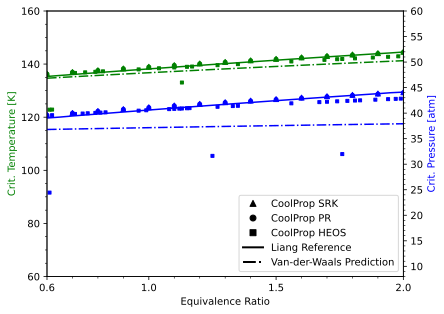

In [56]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(phi,T_crit_list_SRK, ' ', color='g', marker='^', markersize=5, markerfacecolor='g', markevery=2, label='$SRK Critical Temperature$')
ax1.plot(phi,T_crit_list_PR, ' ', color='g', marker='o', markersize=4, markerfacecolor='g', markevery=2, label='$PR Critical Temperature$')
ax1.plot(phi2_red,T_crit_list_HEOS, ' ', color='g', marker='s', markersize=3, markerfacecolor='g', markevery=3, label='$HEOS Critical Temperature$')
ax1.plot(phi,T_c_VdW_CH4, 'g-.', label='$VdW Pseudocritical Temperature$')
#ax1.plot(phi,T_c_mix_CH4, 'g--', label='$Pseudocritical Temperature$')
ax1.plot(CH4_critP['phi'], CH4_critP['T'], 'g-', label='$Reference Critical Temperature$')
ax2.plot(phi,p_crit_list_SRK, ' ', color='b', marker='^', markersize=5, markerfacecolor='b', markevery=2, label='$SRK Critical Pressure$')
ax2.plot(phi,p_crit_list_PR, ' ', color='b', marker='o', markersize=4, markerfacecolor='b', markevery=2, label='$SRK Critical Pressure$')
ax2.plot(phi2_red,p_crit_list_HEOS, ' ', color='b', marker='s', markersize=3, markerfacecolor='b', markevery=2, label='$HEOS Critical Pressure$')
ax2.plot(phi,P_c_VdW_CH4, 'b-.', label='$VdW Pseudocritical Pressure$')
#ax2.plot(phi,P_c_mix_CH4, 'b--', label='$Pseudocritical Pressure$')
ax2.plot(CH4_critP['phi'], CH4_critP['p'], 'b-', label='$Reference Critical Pressure$')
ax1.set_xlabel('Equivalence Ratio')
ax1.set_ylabel('Crit. Temperature [K]', color='g')
ax2.set_ylabel('Crit. Pressure [atm]', color='b')
ax1.set_xlim(0.6, 2)
ax1.set_ylim(60, 160)
ax2.set_xlim(0.6, 2)
ax2.set_ylim(8, 60)
ax1.set_xticks([0.6, 1, 1.5, 2])
ax1.set_yticks([60, 80, 100, 120, 140, 160])
ax2.set_yticks([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
ax1.minorticks_on()
ax2.minorticks_on()
custom_legend_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='^', label='CoolProp SRK'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='o', label='CoolProp PR'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='s', label='CoolProp HEOS'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Liang Reference'),
#    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Kays Law Prediction'),
    Line2D([0], [0], color='black', lw=2, linestyle='-.', label='Van-der-Waals Prediction')
]
ax1.legend(handles=custom_legend_lines, loc='lower right')
plt.savefig("Graphs/pTCrit of CH4.svg")
plt.show()

SRK and PR both agree closely with each other, and overpredict slightly at low phis compared Law Reference. \
HEOS - if it delivers values at all - has outliers (due to multiple "valid" critical points found at those phis), and does not coincide with reference at higher phis visibly. \
Kays Law and VdW come reasonably close for predicting Tcrit at all phis, but are inaccurate for pCrit especially at higher phis.

Now lets try Hydrogen:

In [26]:
#SRK
#Arrays get indexed with _H2
T_crit_list_SRK_H2 = []
p_crit_list_SRK_H2 = []

AS5 = CP.AbstractState("SRK", "N2&H2&O2")
for i in phi:
    gas1.set_equivalence_ratio(i, fuel, oxidizer) #H2 fuel
    AS5.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])
    pts5 = AS5.all_critical_points()
    for pt5 in pts5:
        if pt5.stable:
            T_crit_list_SRK_H2.append (pt5.T)
            p_crit_list_SRK_H2.append (pt5.p / 101325)

In [27]:
#PR
T_crit_list_PR_H2 = []
p_crit_list_PR_H2 = []


AS5 = CP.AbstractState("PR", "N2&H2&O2")
for i in phi:
    gas1.set_equivalence_ratio(i, fuel, oxidizer)
    AS5.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])
    pts5 = AS5.all_critical_points()
    for pt5 in pts5:
        if pt5.stable:
            T_crit_list_PR_H2.append (pt5.T)
            p_crit_list_PR_H2.append (pt5.p / 101325)

In [28]:
#HEOS
T_crit_list_HEOS_H2 = []
p_crit_list_HEOS_H2 = []
phi2_red_H2 = []

AS6 = CP.AbstractState("HEOS", "N2&H2&O2")
for i in phi2:
    gas1.set_equivalence_ratio(i, fuel, oxidizer)
    AS6.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])
    try:
        pts6 = AS6.all_critical_points()
        for pt6 in pts6:
            if pt6.stable: #Only "stable" results
                T_crit_list_HEOS_H2.append (pt6.T)
                p_crit_list_HEOS_H2.append (pt6.p / 101325)
                phi2_red_H2.append (i)
    except Exception as e:
        print("Error processing point at phi", i, e)
        continue  # Continue with next point

In [29]:
H2_critP = pd.read_csv('Fluid Reference Data/Law_Fig2_H2.csv')
H2_critP.head() #Looks good

,phi,p,T
0,0.60,25.837759,108.611254
1,0.65,25.190512,107.140606
2,0.70,24.526053,105.706336
3,0.75,23.915836,104.376376
4,0.80,23.305619,103.020338


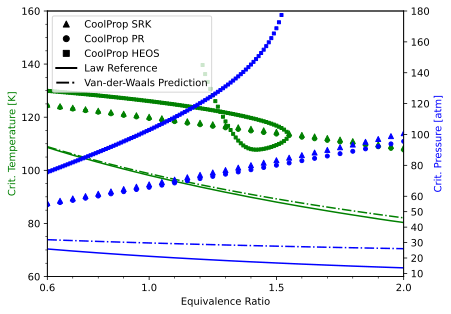

In [30]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(phi,T_crit_list_SRK_H2, ' ', color='g', marker='^', markersize=5, markerfacecolor='g', label='$SRK Critical Temperature$')
ax1.plot(phi,T_crit_list_PR_H2, ' ', color='g', marker='o', markersize=4, markerfacecolor='g', label='$PR Critical Temperature$')
ax1.plot(phi2_red_H2,T_crit_list_HEOS_H2, ' ', color='g', marker='s', markersize=3, markerfacecolor='g', label='$HEOS Critical Temperature$')
ax1.plot(phi,T_c_VdW_H2, 'g-.', label='$VdW Pseudocritical Temperature$')
#ax1.plot(phi,T_c_mix_H2, 'g--', label='$Pseudocritical Temperature$')
ax1.plot(H2_critP['phi'], H2_critP['T'], 'g-', label='$Reference Critical Pressure$')
ax2.plot(phi,p_crit_list_SRK_H2, ' ', color='b', marker='^', markersize=5, markerfacecolor='b', label='$SRK Critical Pressure$')
ax2.plot(phi,p_crit_list_PR_H2, ' ', color='b', marker='o', markersize=4, markerfacecolor='b', label='$SRK Critical Pressure$')
ax2.plot(phi2_red_H2,p_crit_list_HEOS_H2, ' ', color='b', marker='s', markersize=3, markerfacecolor='b', label='$HEOS Critical Pressure$')
ax2.plot(phi,P_c_VdW_H2, 'b-.', label='$VdW Pseudocritical Pressure$')
#ax2.plot(phi,P_c_mix_H2, 'b--', label='$Pseudocritical Pressure$')
ax2.plot(H2_critP['phi'], H2_critP['p'], 'b-', label='$Reference Critical Pressure$')
ax1.set_xlabel('Equivalence Ratio')
ax1.set_ylabel('Crit. Temperature [K]', color='g')
ax2.set_ylabel('Crit. Pressure [atm]', color='b')
ax1.set_xlim(0.6, 2)
ax1.set_ylim(60, 160)
ax2.set_xlim(0.6, 2)
ax2.set_ylim(8, 180)
ax1.set_xticks([0.6, 1, 1.5, 2])
ax1.set_yticks([60, 80, 100, 120, 140, 160])
ax2.set_yticks([10, 20, 30, 40, 50, 60, 80, 100, 120, 140, 160, 180])
ax1.minorticks_on()
custom_legend_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='^', label='CoolProp SRK'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='o', label='CoolProp PR'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='s', label='CoolProp HEOS'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Law Reference'),
#    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Kays Law Prediction'),
    Line2D([0], [0], color='black', lw=2, linestyle='-.', label='Van-der-Waals Prediction')
]
ax1.legend(handles=custom_legend_lines, loc='upper left')
plt.savefig("Graphs/pTCrit of H2.svg")
plt.show()

This is a mess! \
All CoolProp backends are massively off from our reference! \
- CoolProps SRK and PR backends are grouped together, but disagree on pCrit at higher phis. Tcrit has a downward trend just as reference, but Pcrit increases instead. Both are far off from reference.
- CoolProps HEOS backend often predicts multiple Tcrit for each phi, and a rapidly balooning Pcrit. Additionally, there are no values above a phi of 1.54! The all_critical_points routine for HEOS Hydrogen mixes silently fails at those phis.

Our Manual Predictions (Kays Law & VdW) come closest to reference in terms of value and general trend, but diverge further at higher phis.

# Tuning binary interaction parameters

CoolProp lets us customize the binary interaction parameters both for the Cubic and HEOS backends. \
We will be using the Low Level Interface for this (see https://www.coolprop.org/fluid_properties/Mixtures.html#using-your-own-interaction-parameters) \
Lets try accessing the parameters in the HEOS backend first:

In [31]:
#Taking a look at starting interaction parameters
AS_mod = CP.AbstractState("HEOS", "N2&H2&O2")
#0 is N2, 1 is H2, 2 is O2
print('N2-H2 Interaction Parameters:')
print(AS_mod.get_binary_interaction_double(0, 1, 'betaT'),AS_mod.get_binary_interaction_double(0, 1, 'gammaT'),\
      AS_mod.get_binary_interaction_double(0, 1, 'betaV'),AS_mod.get_binary_interaction_double(0, 1, 'gammaV'))
print(' ')
print('H2-O2 Interaction Parameters:')
print(AS_mod.get_binary_interaction_double(1, 2, 'betaT'),AS_mod.get_binary_interaction_double(1, 2, 'gammaT'),\
      AS_mod.get_binary_interaction_double(1, 2, 'betaV'),AS_mod.get_binary_interaction_double(1, 2, 'gammaV'))
print(' ')
print('N2-O2 Interaction Parameters:')
print(AS_mod.get_binary_interaction_double(0, 2, 'betaT'),AS_mod.get_binary_interaction_double(0, 2, 'gammaT'),\
      AS_mod.get_binary_interaction_double(0, 2, 'betaV'),AS_mod.get_binary_interaction_double(0, 2, 'gammaV'))

N2-H2 Interaction Parameters:
0.9461343370000002 1.175696583 0.9725320649999999 0.970115357
 
H2-O2 Interaction Parameters:
1.0 1.0 1.0 1.0
 
N2-O2 Interaction Parameters:
0.997190589 0.995157044 0.99952177 0.997082328


It seems the Interaction parameters for H2-O2 have been approximated using the Lorentz-Berthelot Method (all are set to 1). \

In [32]:
#Setting Fractions for a phi of 1
gas1.set_equivalence_ratio(1, fuel, oxidizer)

In [33]:
#Initializing AS_mod
AS_mod = CP.AbstractState("HEOS", "N2&H2&O2")
AS_mod.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])

#Resulting Critical Properties
print ('Unmodified HEOS:')
pts_mod = AS_mod.all_critical_points()
for pt_mod in pts_mod:
    if pt_mod.stable: #Only "stable" results
        print(pt_mod.T)
        print (pt_mod.p / 101325)

Unmodified HEOS:
126.05583339608778
102.94691284011917


In [34]:
#Reference Values from the Law_Fig2_H2.csv
Reference_P = H2_critP.iloc[9, 1] #location of pCrit at 1 phi
Reference_T = H2_critP.iloc[9, 2] #location of Tcrit at 1 phi
print ('Law Reference:')
print (Reference_T)
print (Reference_P)

Law Reference:
96.9833622718752
20.6138842845868


Lets try changing the H2-O2 parameters to those of H2-N2:

In [35]:
#These changes are only per-object and get overwritten when reinitializing the AbstractState!
AS_mod.set_binary_interaction_double(1, 2, 'betaT', 0.946134337)
AS_mod.set_binary_interaction_double(1, 2, 'gammaT', 1.175696583)
AS_mod.set_binary_interaction_double(1, 2, 'betaV', 0.972532065)
AS_mod.set_binary_interaction_double(1, 2, 'gammaV', 0.970115357)

#Check that the parameters have been applied
print(AS_mod.get_binary_interaction_double(1, 2, 'betaT'),AS_mod.get_binary_interaction_double(1, 2, 'gammaT'),\
      AS_mod.get_binary_interaction_double(1, 2, 'betaV'),AS_mod.get_binary_interaction_double(1, 2, 'gammaV'))

0.946134337 1.175696583 0.972532065 0.970115357


In [36]:
#Lets take a look at the changes
print ('Modified HEOS:')
AS_mod.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])
pts_mod = AS_mod.all_critical_points()
for pt_mod in pts_mod:
    if pt_mod.stable: #Only "stable" results
        print(pt_mod.T)
        print (pt_mod.p / 101325)

Modified HEOS:
124.83111815125625
92.25484349850768


Lets calculate other phis as well:

In [37]:
#HEOS
T_mod_list_HEOS = []
p_mod_list_HEOS = []
phi2_mod_red = []

for i in phi2:
    gas1.set_equivalence_ratio(i, fuel, oxidizer)
    AS_mod.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])
    try:
        pts_mod = AS_mod.all_critical_points()
        for pt_mod in pts_mod:
            if pt_mod.stable: #Only "stable" results
                T_mod_list_HEOS.append (pt_mod.T)
                p_mod_list_HEOS.append (pt_mod.p / 101325)
                phi2_mod_red.append (i)
    except Exception as e:
        print("Error processing point at phi", i, e)
        continue  # Continue with next point

In [38]:
#Double Checking that the changed parameters are still active
print(AS_mod.get_binary_interaction_double(1, 2, 'betaT'),AS_mod.get_binary_interaction_double(1, 2, 'gammaT'),\
      AS_mod.get_binary_interaction_double(1, 2, 'betaV'),AS_mod.get_binary_interaction_double(1, 2, 'gammaV'))

0.946134337 1.175696583 0.972532065 0.970115357


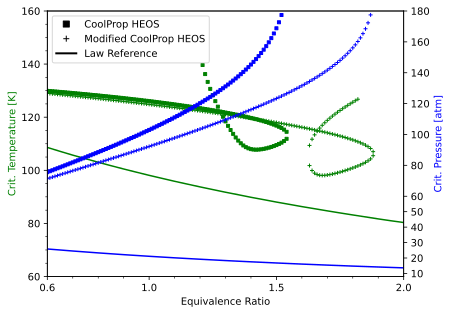

In [39]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(phi2_red_H2,T_crit_list_HEOS_H2, ' ', color='g', marker='s', markersize=3, markerfacecolor='g', label='$HEOS Critical Temperature$')
ax1.plot(phi2_mod_red,T_mod_list_HEOS, ' ', color='g', marker='+', markersize=4, markerfacecolor='g', label='$Parameter Modified HEOS Critical Temperature$')
ax1.plot(H2_critP['phi'], H2_critP['T'], 'g-', label='$Reference Critical Pressure$')
ax2.plot(phi2_red_H2,p_crit_list_HEOS_H2, ' ', color='b', marker='s', markersize=3, markerfacecolor='b', label='$HEOS Critical Pressure$')
ax2.plot(phi2_mod_red,p_mod_list_HEOS, ' ', color='b', marker='+', markersize=4, markerfacecolor='b', label='$Parameter Modified HEOS Critical Pressure$')
ax2.plot(H2_critP['phi'], H2_critP['p'], 'b-', label='$Reference Critical Pressure$')
ax1.set_xlabel('Equivalence Ratio')
ax1.set_ylabel('Crit. Temperature [K]', color='g')
ax2.set_ylabel('Crit. Pressure [atm]', color='b')
ax1.set_xlim(0.6, 2)
ax1.set_ylim(60, 160)
ax2.set_xlim(0.6, 2)
ax2.set_ylim(8, 180)
ax1.set_xticks([0.6, 1, 1.5, 2])
ax1.set_yticks([60, 80, 100, 120, 140, 160])
ax2.set_yticks([10, 20, 30, 40, 50, 60, 80, 100, 120, 140, 160, 180])
ax1.minorticks_on()
custom_legend_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='s', label='CoolProp HEOS'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='+', label='Modified CoolProp HEOS'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Law Reference')
]
ax1.legend(handles=custom_legend_lines, loc='upper left')
plt.savefig("Graphs/pTCrit of H2 HEOS Modified.svg")
plt.show()

Lets try tuning the parameters to get a lower Pressure: \
We will perform a grid search with a rough step size at a single equivalence ratio (to save on calculation time), then check which parameters result in a minimum:

In [40]:
#Setting up arrays, 4x4x5x4 = 320 Combinations
#Change bounds and increase nr of steps if wanted
bT_list = np.linspace(0.94,1.08, 4)
gT_list = np.linspace(1,2, 5)
bV_list = np.linspace(0.9,1.1, 4)
gV_list = np.linspace(0.97,1.17, 4)


#Setting phi to 1 and remixing AS_mod
gas1.set_equivalence_ratio(1, fuel, oxidizer)
AS_mod.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])


reference = H2_critP.iloc[9, 1] #pCrit at phi 1

import itertools #Importing itertools to do a grid search

The search Loop follows. Careful! It takes a while to calculate

In [41]:
#Initialising Final value arrays
P_minlist = []
I_minlist = []

#Search Loop
for bT, gT, bV, gV in itertools.product(bT_list, gT_list, bV_list, gV_list):
    AS_mod.set_binary_interaction_double(1, 2, 'betaT', bT)
    AS_mod.set_binary_interaction_double(1, 2, 'gammaT', gT)
    AS_mod.set_binary_interaction_double(1, 2, 'betaV', bV)
    AS_mod.set_binary_interaction_double(1, 2, 'gammaV', gV)
    pts_mod = AS_mod.all_critical_points()
    try:
        pts_mod = AS_mod.all_critical_points()
        for pt_mod in pts_mod:
            if pt_mod.stable:
                P_minlist.append(pt_mod.p/101325)
                I_minlist.append((bT, gT, bV, gV))   # Stores the parameter-set
    except ValueError: #Skips Values that error out
        continue

In [42]:
# Subtract the reference and find the minimum absolute value
# Basically how close we are to our reference
adjusted = [abs(p - reference) for p in P_minlist]
min_index = np.argmin(adjusted)

#Correspond it to the interaction array
bTmin, gTmin, bVmin, gVmin = I_minlist[min_index]

#Print results
print(f"Minimum Pressure: {P_minlist[min_index]:.4f} atm")
print(f"Corresponding parameters:")
print(f"  betaT = {bTmin}")
print(f"  gammaT = {gTmin}")
print(f"  betaV = {bVmin}")
print(f"  gammaV = {gVmin}")

Minimum Pressure: 65.9625 atm
Corresponding parameters:
  betaT = 0.94
  gammaT = 2.0
  betaV = 0.9
  gammaV = 1.17


Let's set the values, then calculate other phis:

In [43]:
#Setting the Values
AS_mod.set_binary_interaction_double(1, 2, 'betaT', bTmin)
AS_mod.set_binary_interaction_double(1, 2, 'gammaT', gTmin)
AS_mod.set_binary_interaction_double(1, 2, 'betaV', bVmin)
AS_mod.set_binary_interaction_double(1, 2, 'gammaV', gVmin)

#Recalculating HEOS
T_tuned_list_HEOS = []
p_tuned_list_HEOS = []
phi2_tuned_red = []

for i in phi2:
    gas1.set_equivalence_ratio(i, fuel, oxidizer)
    AS_mod.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])
    try:
        pts_mod = AS_mod.all_critical_points()
        for pt_mod in pts_mod:
            if pt_mod.stable: #Only "stable" results
                T_tuned_list_HEOS.append (pt_mod.T)
                p_tuned_list_HEOS.append (pt_mod.p / 101325)
                phi2_tuned_red.append (i)
    except Exception as e:
        print("Error processing point at phi", i, e)
        continue  # Continue with next point

In [44]:
#Double Checking that the changed parameters have actually been set correctly and used
print(AS_mod.get_binary_interaction_double(1, 2, 'betaT'),AS_mod.get_binary_interaction_double(1, 2, 'gammaT'),\
      AS_mod.get_binary_interaction_double(1, 2, 'betaV'),AS_mod.get_binary_interaction_double(1, 2, 'gammaV'))

0.94 2.0 0.9 1.17


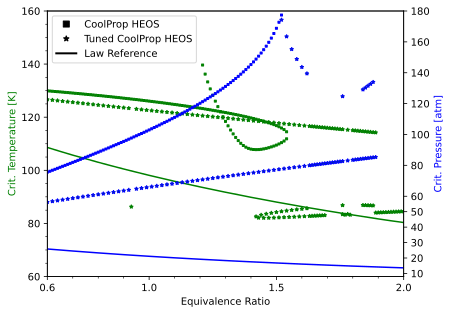

In [45]:
#Plotting the tuned results
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(phi2_red_H2,T_crit_list_HEOS_H2, ' ', color='g', marker='s', markersize=2, markerfacecolor='g', label='$HEOS Critical Temperature$')
ax1.plot(phi2_tuned_red,T_tuned_list_HEOS, ' ', color='g', marker='*', markersize=4, markerfacecolor='g', markevery=2, label='$Parameter Tuned HEOS Critical Temperature$')
ax1.plot(H2_critP['phi'], H2_critP['T'], 'g-', label='$Reference Critical Pressure$')
ax2.plot(phi2_red_H2,p_crit_list_HEOS_H2, ' ', color='b', marker='s', markersize=2, markerfacecolor='b', label='$HEOS Critical Pressure$')
ax2.plot(phi2_tuned_red,p_tuned_list_HEOS, ' ', color='b', marker='*', markersize=4, markerfacecolor='g', markevery=2, label='$Parameter Tuned HEOS Critical Temperature$')
ax2.plot(H2_critP['phi'], H2_critP['p'], 'b-', label='$Reference Critical Pressure$')
ax1.set_xlabel('Equivalence Ratio')
ax1.set_ylabel('Crit. Temperature [K]', color='g')
ax2.set_ylabel('Crit. Pressure [atm]', color='b')
ax1.set_xlim(0.6, 2)
ax1.set_ylim(60, 160)
ax2.set_xlim(0.6, 2)
ax2.set_ylim(8, 180)
ax1.set_xticks([0.6, 1, 1.5, 2])
ax1.set_yticks([60, 80, 100, 120, 140, 160])
ax2.set_yticks([10, 20, 30, 40, 50, 60, 80, 100, 120, 140, 160, 180])
ax1.minorticks_on()
custom_legend_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='s', label='CoolProp HEOS'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='*', label='Tuned CoolProp HEOS'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Law Reference')
]
ax1.legend(handles=custom_legend_lines, loc='upper left')
plt.savefig("Graphs/pTCrit of H2 Tuned InteractionParameters.svg")
plt.show()

Overall: Changing parameters for the HEOS backend influences the results majorly. To get close to reference would require a fine step search over a 4D-Grid Space.

Onto the Cubics: Both use the kij binary interaction parameter, which is defined internally for each binary pair, and can be modified using the "set_binary_interaction_double" function. \
CoolProp rarely has any values for the kij parameter! In these cases, the parameter gets set to 0 by default (usually good enough), then gets grabbed from other sources like REFPROP. (We dont have access to REFPROP)

In [46]:
AS_SRKmod = CP.AbstractState("SRK", "N2&H2&O2")
AS_SRKmod2 = CP.AbstractState("SRK", "N2&CH4&O2")

print ('Interaction Parameters of H2-Air:')
print(AS_SRKmod.get_binary_interaction_double(0,1,"kij"),AS_SRKmod.get_binary_interaction_double(1,2,"kij"),\
      AS_SRKmod.get_binary_interaction_double(0,2,"kij"))
print ('Interaction Parameters of CH4-Air:')
print(AS_SRKmod2.get_binary_interaction_double(0,1,"kij"),AS_SRKmod2.get_binary_interaction_double(1,2,"kij"),\
      AS_SRKmod2.get_binary_interaction_double(0,2,"kij"))

#All Parameters are 0 (standard value)

Interaction Parameters of H2-Air:
0.0 0.0 0.0
Interaction Parameters of CH4-Air:
0.0 0.0 0.0


In [47]:
gas1.set_equivalence_ratio(1, fuel, oxidizer)
AS_SRKmod.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])

#Resulting Critical Properties
print ('Unmodified SRK:')
pts_mod = AS_SRKmod.all_critical_points()
for pt_mod in pts_mod:
    if pt_mod.stable: #Only "stable" results
        print(pt_mod.T)
        print (pt_mod.p / 101325)

Unmodified SRK:
120.17183929788499
67.70122013450785


Lets try changing the parameter:

In [48]:
AS_SRKmod.set_binary_interaction_double(0, 1, "kij", -0.1)
AS_SRKmod.set_binary_interaction_double(1, 2, "kij", 0)
AS_SRKmod.set_binary_interaction_double(0, 2, "kij", 0.1)

print(AS_SRKmod.get_binary_interaction_double(0,1,"kij"),AS_SRKmod.get_binary_interaction_double(1,2,"kij"),\
      AS_SRKmod.get_binary_interaction_double(0,2,"kij"))

-0.1 0.0 0.1


In [49]:
print ('Modified SRK:')
pts_mod = AS_SRKmod.all_critical_points()
for pt_mod in pts_mod:
    if pt_mod.stable: #Only "stable" results
        print(pt_mod.T)
        print (pt_mod.p / 101325)

Modified SRK:
117.12111834414416
59.09642044050814


Now, the same as HEOS, we will try varying the kij parameters from -0.1 to 0.6 and perform a grid search. \
Due to their similarities, we will use SRKs found parameters both for SRK and PR:

In [50]:
#Setting three separate kijs, so that search space remains large, 8x8x8 = 512 Value  Combinations
#Change bounds and nr of steps if wanted
kij1_list = np.linspace(-0.1,0.6, 8)
kij2_list = np.linspace(-0.1,0.6, 8)
kij3_list = np.linspace(-0.1,0.6, 8)

reference = H2_critP.iloc[9, 1]  # pCrit at phi 1

#Setting phi to 1
gas1.set_equivalence_ratio(1, fuel, oxidizer)

AS_SRKmod = CP.AbstractState("SRK", "N2&H2&O2")
AS_SRKmod.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])

# Import itertools if not already done so
# import itertools

In [51]:
#Initialising Final value arrays
P_minlist = []
I_minlist = []

#Search Loop
for kij1, kij2, kij3 in itertools.product(kij1_list, kij2_list, kij3_list):
    AS_SRKmod.set_binary_interaction_double(0, 1, "kij", kij1)
    AS_SRKmod.set_binary_interaction_double(1, 2, "kij", kij2)
    AS_SRKmod.set_binary_interaction_double(0, 2, "kij", kij3)
    try:
        pts_mod = AS_SRKmod.all_critical_points()
        for pt_mod in pts_mod:
            if pt_mod.stable:
                P_minlist.append(pt_mod.p/101325)
                I_minlist.append((kij1, kij2, kij3))  
    except ValueError: #Skip/Bypass errors
        continue


# Subtract the reference and calculate the minimum of the absolute value
# Basically how close we are to reference
adjusted = [abs(p - reference) for p in P_minlist]
min_index = np.argmin(adjusted)


#Correspond it to the interaction array
kij1, kij2, kij3 = I_minlist[min_index]

#Print results
print(f"Found Pressure at phi 1: {P_minlist[min_index]:.4f} atm")
print(f"Corresponding parameters:")
print(f"  N2-H2 = {kij1}")
print(f"  H2-O2 = {kij2}")
print(f"  N2-O2 = {kij3}")

Found Pressure at phi 1: 52.0130 atm
Corresponding parameters:
  N2-H2 = -0.1
  H2-O2 = -0.1
  N2-O2 = 0.3999999999999999


In [52]:
#Using calculated values in SRK

T_crit_list_SRKtune = []
p_crit_list_SRKtune = []
phi_SRKtune = []

AS_SRKtune = CP.AbstractState("SRK", "N2&H2&O2")
AS_SRKtune.set_binary_interaction_double(0, 1, "kij", kij1)
AS_SRKtune.set_binary_interaction_double(1, 2, "kij", kij2)
AS_SRKtune.set_binary_interaction_double(0, 2, "kij", kij3)

for i in phi:
    gas1.set_equivalence_ratio(i, fuel, oxidizer)
    AS_SRKtune.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])
    pts_mod = AS_SRKtune.all_critical_points()
    for pt_mod in pts_mod:
        if pt_mod.stable:
            T_crit_list_SRKtune.append(pt_mod.T)
            p_crit_list_SRKtune.append(pt_mod.p / 101325)
            phi_SRKtune.append (i)

In [53]:
#Same for PR

T_crit_list_PRtune = []
p_crit_list_PRtune = []
phi_PRtune = []

AS_PRtune = CP.AbstractState("PR", "N2&H2&O2")
AS_PRtune.set_binary_interaction_double(0, 1, "kij", kij1)
AS_PRtune.set_binary_interaction_double(1, 2, "kij", kij2)
AS_PRtune.set_binary_interaction_double(0, 2, "kij", kij3)

for i in phi:
    gas1.set_equivalence_ratio(i, fuel, oxidizer)
    AS_PRtune.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])
    pts_mod = AS_PRtune.all_critical_points()
    for pt_mod in pts_mod:
        if pt_mod.stable:
            T_crit_list_PRtune.append(pt_mod.T)
            p_crit_list_PRtune.append(pt_mod.p / 101325)
            phi_PRtune.append (i)

Now to plot the results:

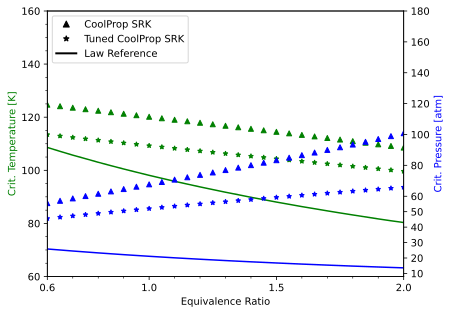

In [54]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(phi,T_crit_list_SRK_H2, ' ', color='g', marker='^', markersize=5, markerfacecolor='g', label='$SRK Critical Temperature$')
ax1.plot(phi_SRKtune,T_crit_list_SRKtune, ' ', color='g', marker='*', markersize=5, markerfacecolor='g', label='$Tuned SRK Critical Temperature$')
ax1.plot(H2_critP['phi'], H2_critP['T'], 'g-', label='$Reference Critical Pressure$')
ax2.plot(phi,p_crit_list_SRK_H2, ' ', color='b', marker='^', markersize=5, markerfacecolor='b', label='$SRK Critical Pressure$')
ax2.plot(phi_SRKtune,p_crit_list_SRKtune, ' ', color='b', marker='*', markersize=5, markerfacecolor='b', label='$Tuned SRK Critical Pressure$')
ax2.plot(H2_critP['phi'], H2_critP['p'], 'b-', label='$Reference Critical Pressure$')
ax1.set_xlabel('Equivalence Ratio')
ax1.set_ylabel('Crit. Temperature [K]', color='g')
ax2.set_ylabel('Crit. Pressure [atm]', color='b')
ax1.set_xlim(0.6, 2)
ax1.set_ylim(60, 160)
ax2.set_xlim(0.6, 2)
ax2.set_ylim(8, 180)
ax1.set_xticks([0.6, 1, 1.5, 2])
ax1.set_yticks([60, 80, 100, 120, 140, 160])
ax2.set_yticks([10, 20, 30, 40, 50, 60, 80, 100, 120, 140, 160, 180])
ax1.minorticks_on()
custom_legend_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='^', label='CoolProp SRK'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='*', label='Tuned CoolProp SRK'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Law Reference'),
]
ax1.legend(handles=custom_legend_lines, loc='upper left')
plt.savefig("Graphs/pTCrit of H2 SRK Tuned.svg")
plt.show()

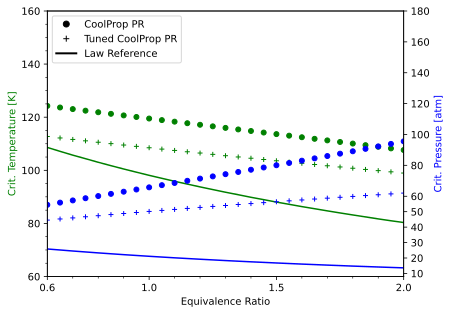

In [55]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(phi,T_crit_list_PR_H2, ' ', color='g', marker='o', markersize=5, markerfacecolor='g', label='$PR Critical Temperature$')
ax1.plot(phi_PRtune,T_crit_list_PRtune, ' ', color='g', marker='+', markersize=5, markerfacecolor='g', label='$Tuned PR Critical Temperature$')
ax1.plot(H2_critP['phi'], H2_critP['T'], 'g-', label='$Reference Critical Pressure$')
ax2.plot(phi,p_crit_list_PR_H2, ' ', color='b', marker='o', markersize=5, markerfacecolor='b', label='$PR Critical Pressure$')
ax2.plot(phi_PRtune,p_crit_list_PRtune, ' ', color='b', marker='+', markersize=5, markerfacecolor='b', label='$Tuned PR Critical Pressure$')
ax2.plot(H2_critP['phi'], H2_critP['p'], 'b-', label='$Reference Critical Pressure$')
ax1.set_xlabel('Equivalence Ratio')
ax1.set_ylabel('Crit. Temperature [K]', color='g')
ax2.set_ylabel('Crit. Pressure [atm]', color='b')
ax1.set_xlim(0.6, 2)
ax1.set_ylim(60, 160)
ax2.set_xlim(0.6, 2)
ax2.set_ylim(8, 180)
ax1.set_xticks([0.6, 1, 1.5, 2])
ax1.set_yticks([60, 80, 100, 120, 140, 160])
ax2.set_yticks([10, 20, 30, 40, 50, 60, 80, 100, 120, 140, 160, 180])
ax1.minorticks_on()
custom_legend_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='o', label='CoolProp PR'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='+', label='Tuned CoolProp PR'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Law Reference'),
]
ax1.legend(handles=custom_legend_lines, loc='upper left')
plt.savefig("Graphs/pTCrit of H2 PR Tuned.svg")
plt.show()

Despite some efforts, these results are very different compared to what Law et al get.